In [88]:
import pandas as pd
import os
import numpy as np
import random
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler,LabelEncoder,OneHotEncoder,OrdinalEncoder,MultiLabelBinarizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_recall_curve, roc_auc_score, roc_curve, confusion_matrix, classification_report, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, average_precision_score
from sklearn.tree import DecisionTreeClassifier, plot_tree

from matplotlib import pyplot as plt

from hyperopt import fmin, tpe, hp, Trials, STATUS_OK, STATUS_FAIL
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
SEED = 123
random.seed(SEED)
np.random.seed(SEED)


In [3]:
df = pd.read_csv('./Dataset/healthcare-dataset-stroke-data.csv')
print(df.shape)
df.head()

(5110, 12)


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [5]:
df = df.drop(columns=['id'])
df = df.drop_duplicates().reset_index(drop=True)
cat_cols = []
num_cols = []

for i in df.columns:
    # print(str(df[i].dtype))
    if 'int' in str(df[i].dtype) or 'float' in str(df[i].dtype):
        num_cols.append(i)
    else:
        cat_cols.append(i)

num_cols = [i for i in num_cols if i not in ['hypertension','heart_disease','stroke']]
cat_cols.extend(['hypertension','heart_disease','stroke'])

print(f'Categorical: {cat_cols}')
print(f'Numeric: {num_cols}')

Categorical: ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'hypertension', 'heart_disease', 'stroke']
Numeric: ['age', 'avg_glucose_level', 'bmi']


In [7]:
df = df.dropna(subset=['bmi']).reset_index(drop=True)
df = df[df['gender']!='Other']

In [8]:
bin_cols = ['Residence_type','ever_married','gender']

ord_enc = OrdinalEncoder(categories=[['never smoked','Unknown','formerly smoked','smokes']])
ohe_enc = OneHotEncoder(sparse_output=False)
bin_enc_dict = {}

In [9]:
oh_encoded = ohe_enc.fit_transform(pd.DataFrame(df['work_type']))
one_hot_df = pd.DataFrame(oh_encoded, columns=ohe_enc.get_feature_names_out(['work_type']))

In [10]:
data = df.copy().reset_index(drop=True)
data['smoking_status'] = ord_enc.fit_transform(df[['smoking_status']])
for i in bin_cols:
    bin_enc_dict[i] = LabelEncoder()
    data[i] = bin_enc_dict[i].fit_transform(data[i])

data = pd.concat([data.drop(columns=['work_type']),one_hot_df.astype('int')],axis=1)
data.head()

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children
0,1,67.0,0,1,1,1,228.69,36.6,2.0,1,0,0,1,0,0
1,1,80.0,0,1,1,0,105.92,32.5,0.0,1,0,0,1,0,0
2,0,49.0,0,0,1,1,171.23,34.4,3.0,1,0,0,1,0,0
3,0,79.0,1,0,1,0,174.12,24.0,0.0,1,0,0,0,1,0
4,1,81.0,0,0,1,1,186.21,29.0,2.0,1,0,0,1,0,0


In [12]:
x = data[data.columns.drop('stroke')]
y = data['stroke']
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2,random_state=123)

ros = SMOTE(random_state=SEED, sampling_strategy='minority')
x_train,y_train = ros.fit_resample(x_train,y_train)

print(x_train.shape,x_test.shape)

(7514, 14) (982, 14)


In [13]:
rob_scaler = RobustScaler()
x_train[num_cols] = rob_scaler.fit_transform(x_train[num_cols])
x_test[num_cols] = rob_scaler.transform(x_test[num_cols])

In [90]:
model = DecisionTreeClassifier(criterion='gini', max_depth=5,min_samples_leaf=1, random_state=SEED)
model.fit(x_train, y_train)

y_preds = model.predict(x_test)
y_preds_proba = model.predict_proba(x_test)

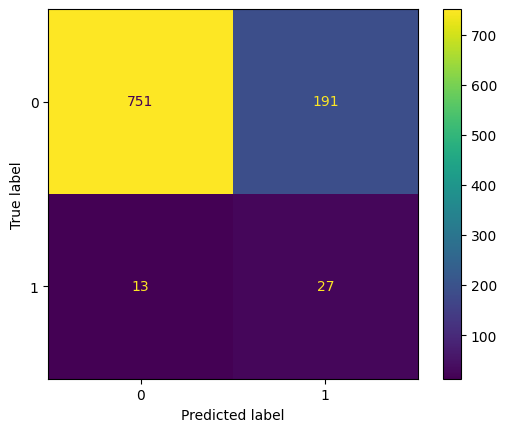

In [61]:
cm = confusion_matrix(y_test,y_preds,labels = [0,1])
cm_plot = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
cm_plot.plot()


In [62]:
print(classification_report(y_test,y_pred=y_preds))

              precision    recall  f1-score   support

           0       0.98      0.80      0.88       942
           1       0.12      0.68      0.21        40

    accuracy                           0.79       982
   macro avg       0.55      0.74      0.54       982
weighted avg       0.95      0.79      0.85       982



# XAI

In [46]:
n_nodes = model.tree_.node_count
children_left = model.tree_.children_left
children_right = model.tree_.children_right
feature = model.tree_.feature
threshold = model.tree_.threshold
values = model.tree_.value

node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
while len(stack) > 0:
    # `pop` ensures each node is only visited once
    node_id, depth = stack.pop()
    node_depth[node_id] = depth

    # If the left and right child of a node is not the same we have a split
    # node
    is_split_node = children_left[node_id] != children_right[node_id]
    # If a split node, append left and right children and depth to `stack`
    # so we can loop through them
    if is_split_node:
        stack.append((children_left[node_id], depth + 1))
        stack.append((children_right[node_id], depth + 1))
    else:
        is_leaves[node_id] = True

print(
    "The binary tree structure has {n} nodes and has "
    "the following tree structure:\n".format(n=n_nodes)
)
for i in range(n_nodes):
    if is_leaves[i]:
        print(
            "{space}node={node} is a leaf node with value={value}.".format(
                space=node_depth[i] * "\t", node=i, value=np.around(values[i], 3)
            )
        )
    else:
        print(
            "{space}node={node} is a split node with value={value}: "
            "go to node {left} if X[:, {feature}] <= {threshold} "
            "else to node {right}.".format(
                space=node_depth[i] * "\t",
                node=i,
                left=children_left[i],
                feature=feature[i],
                threshold=threshold[i],
                right=children_right[i],
                value=np.around(values[i], 3),
            )
        )

The binary tree structure has 57 nodes and has the following tree structure:

node=0 is a split node with value=[[0.5 0.5]]: go to node 1 if X[:, 1] <= -0.24276605248451233 else to node 26.
	node=1 is a split node with value=[[0.89 0.11]]: go to node 2 if X[:, 1] <= -0.4279290437698364 else to node 15.
		node=2 is a split node with value=[[0.954 0.046]]: go to node 3 if X[:, 6] <= -0.19115617871284485 else to node 10.
			node=3 is a split node with value=[[0.901 0.099]]: go to node 4 if X[:, 1] <= -0.7965002357959747 else to node 7.
				node=4 is a split node with value=[[0.958 0.042]]: go to node 5 if X[:, 7] <= -0.13641316443681717 else to node 6.
					node=5 is a leaf node with value=[[0.995 0.005]].
					node=6 is a leaf node with value=[[0.884 0.116]].
				node=7 is a split node with value=[[0.795 0.205]]: go to node 8 if X[:, 6] <= -0.3427087366580963 else to node 9.
					node=8 is a leaf node with value=[[0.954 0.046]].
					node=9 is a leaf node with value=[[0.646 0.354]].
			n

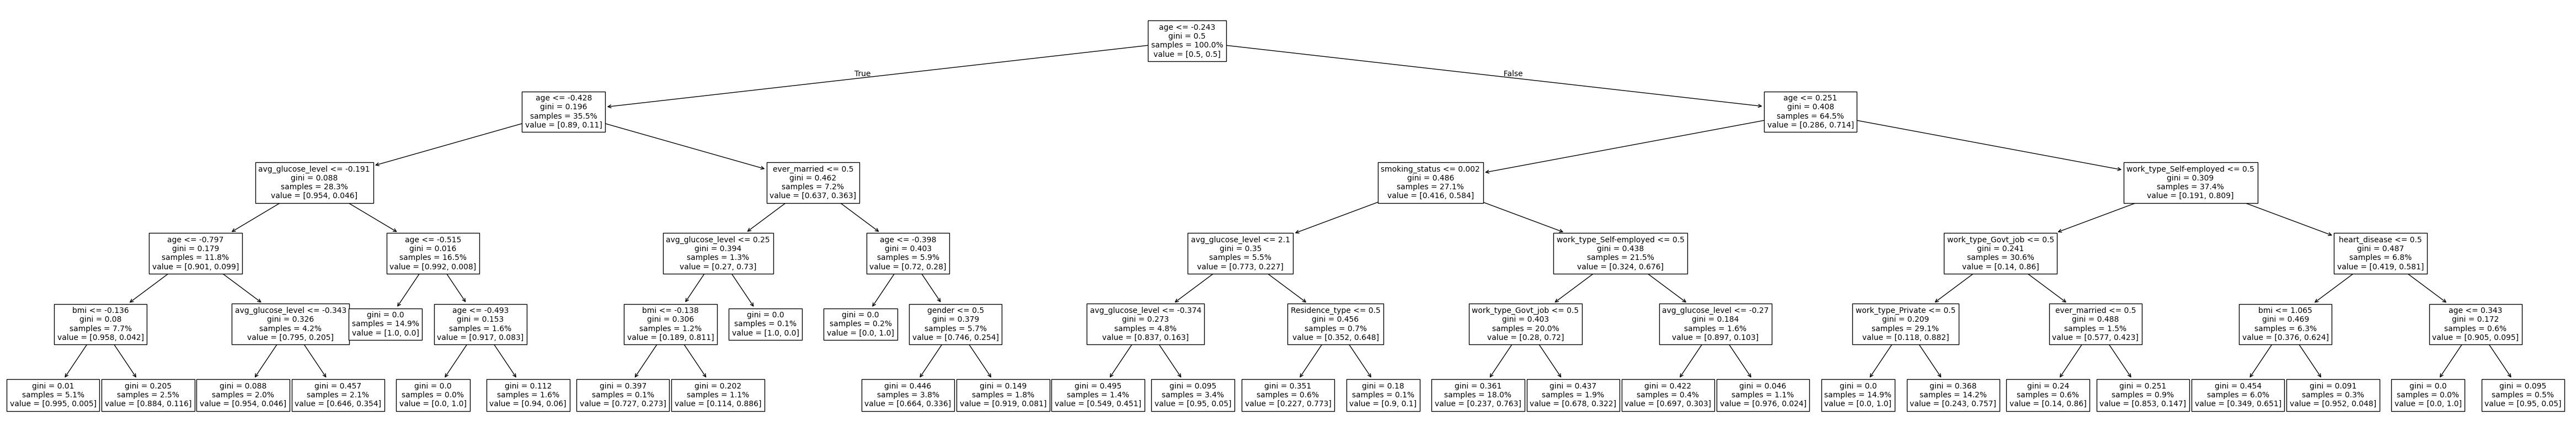

In [56]:
plt.figure(figsize=(60,10))
plot_tree(model, proportion=True, feature_names = x_train.columns, fontsize=10)
plt.show()

<Axes: >

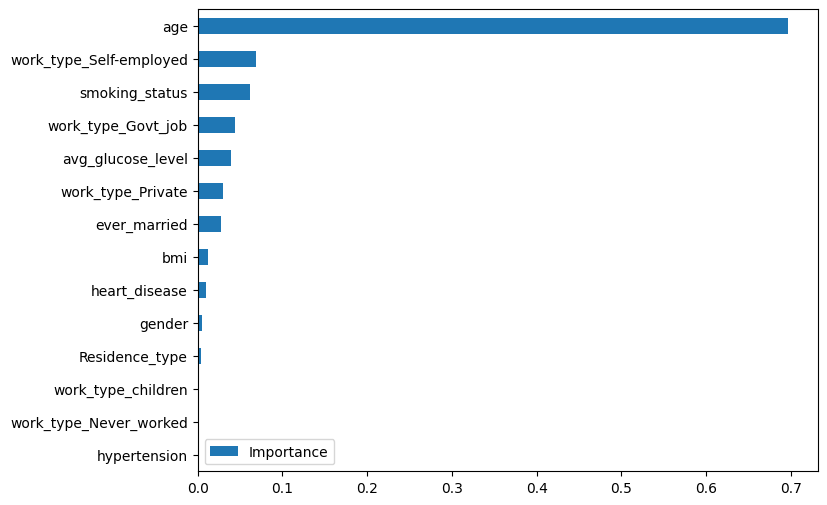

In [60]:
feat_importances = pd.DataFrame(model.feature_importances_, index=x_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=True, inplace=True)
feat_importances.plot(kind='barh', figsize=(8,6))

# GridSearchCV & HyperOpt

In [81]:
parameters = {
    'criterion':('gini','entropy'),
    'max_depth':(5,10,15,20,25),
    'random_state':[SEED]}

In [82]:
model = GridSearchCV(DecisionTreeClassifier(), parameters)
model.fit(x_train, y_train)

y_preds = model.predict(x_test)
y_preds_proba = model.predict_proba(x_test)

In [84]:
model.best_params_

{'criterion': 'entropy', 'max_depth': 25, 'random_state': 123}

In [83]:
model.best_score_

0.9415772981334269

In [86]:
print(classification_report(y_test,y_pred=y_preds))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       942
           1       0.11      0.17      0.13        40

    accuracy                           0.91       982
   macro avg       0.54      0.56      0.54       982
weighted avg       0.93      0.91      0.92       982



### Hyperopt

In [87]:
parameters = {
    'resampling':(None,'SMOTE','RUS','class_weight'),
    'criterion':('gini','entropy'),
    'max_depth':(5,10,15,20,25),
    'random_state':[SEED]
    }

In [137]:
def fit_model(params):
    # print(params)
    # print("Training model . . .")

    x = data[data.columns.drop('stroke')]
    y = data['stroke']
    x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2,random_state=123)

    if params['resampling'] == 'SMOTE':
        ros = SMOTE(random_state=SEED, sampling_strategy='minority')
        x_train,y_train = ros.fit_resample(x_train,y_train)
    elif params['resampling'] == 'RUS':
        rus = RandomUnderSampler(random_state=SEED, sampling_strategy='majority')
        x_train,y_train = rus.fit_resample(x_train,y_train)
    elif params['resampling'] == 'class_weight':
        class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
        params['class_weight'] = dict(enumerate(class_weights))

    del params['resampling']
    model = DecisionTreeClassifier()
    model.set_params(**params)

    model.fit(x_train, y_train)
    y_preds = model.predict(x_test)

    return {'loss':1-recall_score(y_test,y_preds),'params':params,'status': STATUS_OK}


In [114]:
def gs_calculate_max_evals(params):
    print("Calculating max evals . . .")
    num_evals = 1
    for i in params.keys():
        num_evals*=len(params[i])
    return num_evals

def construct_hp_search_space(params):
    print("Building hyperparameter search space . . .")
    search_space = {}
    for i in params.keys():
        search_space[i] = hp.choice(i,params[i])
    return search_space

In [138]:
bayes_trials = Trials()
best_params = fmin(
    fit_model,
    space=construct_hp_search_space(params=parameters),
    algo=tpe.suggest,
    max_evals=gs_calculate_max_evals(params=parameters),
    # max_evals=20,
    trials=bayes_trials,
    rstate=np.random.default_rng(SEED)
)

Building hyperparameter search space . . .
Calculating max evals . . .
100%|██████████| 40/40 [00:00<00:00, 40.24trial/s, best loss: 0.125]              


In [139]:
best_params

{'criterion': 1, 'max_depth': 0, 'random_state': 0, 'resampling': 3}

In [143]:
parameters = {
    'resampling':'class_weight',
    'criterion':'entropy',
    'max_depth':5,
    'random_state':SEED
    }

In [144]:
x = data[data.columns.drop('stroke')]
y = data['stroke']
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2,random_state=123)

class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
parameters['class_weight'] = dict(enumerate(class_weights))

del parameters['resampling']
model = DecisionTreeClassifier()
model.set_params(**parameters)

model.fit(x_train, y_train)
y_preds = model.predict(x_test)

In [145]:
print(classification_report(y_test,y_pred=y_preds))

              precision    recall  f1-score   support

           0       0.99      0.62      0.77       942
           1       0.09      0.88      0.16        40

    accuracy                           0.63       982
   macro avg       0.54      0.75      0.46       982
weighted avg       0.95      0.63      0.74       982



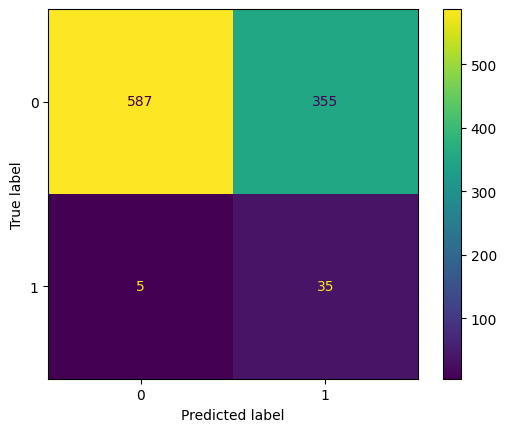

In [146]:
cm = confusion_matrix(y_test,y_preds,labels = [0,1])
cm_plot = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
cm_plot.plot()
